In [ ]:
import pennylane as qml
from pennylane import numpy as qnp
import torch

N = 12

In [ ]:
gate_dict = {
    'RX': qml.RX,
    'RY': qml.RY,
    'RZ': qml.RZ,
    'CNOT': qml.CNOT,
    'IsingXX': qml.IsingXX,
    'IsingYY': qml.IsingYY,
    'IsingZZ': qml.IsingZZ
}

In [ ]:
noise_stdev = 0.1
scale = 1.0

In [ ]:
def near_identity_block(a, b):
    #
    # Pennylane decomposes SU(4) matrix by the following form:
    #
    # ---|---|---         ---RZ---RY---RZ---X---RZ---.--------X---RZ---RY---RZ--- 
    #    | U |       =                      |        |        |
    # ___|---|---         ---RZ---RY---RZ---.---RY---X---RY---.---RZ---RY---RZ---
    # 
    # Number of CNOT gates may be less than this. [see arXiv:0308045, PRA 70, 012310 (2004)]
    # 
    # However, we cannot construct identity matrix using the form above. 
    # And Initialization with Identity block results in stucking in local minima provided by MPS. 
    # So, we should use the following form (though we need more gates...) with parameters having normal distributions.
    #
    # ---|---|---         ---RZ---RY---RZ---|----|---|----|---|----|---RZ---RY---RZ--- 
    #    | U |       =                      | XX |   | YY |   | ZZ |
    # ___|---|---         ---RZ---RY---RZ---|----|---|----|---|----|---RZ---RY---RZ---
    # 
    #
    wl = []
    gl = []
    pm = []
    decomp_out = two_qubit_decomposition(np.eye(4), [a, b])
    for op in decomp_out:
        wl.append(op.wires)
        gl.append(op.name)
        if op.parameters:
            pm.append(op.parameters[0] + scale*np.random.normal(0, noise_stdev))
    return gl, wl, pm

In [ ]:
dev = qml.device('default.qubit', wires=range(12))
coeffs = []
ops = []
for i in range(N-1):
    for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
        coeffs.append(1.0)
        ops.append(op(i) @ op(i+1))
H = qml.Hamiltonian(coeffs, ops)
H

<Hamiltonian: terms=33, wires=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]>


In [ ]:
wire_list = []
params = []
gate_list = []
for G in G_list[::-1]:
    for i in range(len(G)):
        mat, ids = G[i]
        mat = mat.reshape(4, 4)
        # mat = unitary_group.rvs(4)
        mat_d = two_qubit_decomposition(mat, wires=list(ids))
            

        for op in mat_d:
            wire_list.append(op.wires)
            gate_list.append(op.name)
            if op.parameters:
                params.append(op.parameters[0] + np.random.normal(0, noise_stdev))
                
for _ in range(N//2-2):
    for i in range(N-1):
        gates, wire_arr, param_arr = near_identity_block(i, i+1)
        wire_list += (wire_arr)
        gate_list += gates
        params += param_arr
        # mat = unitary_group.rvs(4)
        # mat_d = two_qubit_decomposition(mat, wires=[i, i+1])

        # for op in mat_d:
        #     wire_list.append(op.wires)
        #     gate_list.append(op.name)
        #     if op.parameters:
        #         params.append(op.parameters[0])

/Users/shong/miniconda3/envs/QC/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/shong/miniconda3/envs/QC/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [ ]:
@qml.qnode(dev, interface="torch", diff_method='backprop')
def circuit(param):
    cur = 0
    for i in range(len(gate_list)):
        if i > 0 and abs(wire_list[i-1][0] - wire_list[i][0]) > 2:
            qml.Barrier(only_visual=True)
        if gate_list[i] == 'CNOT':
            gate_dict[gate_list[i]](wire_list[i])
        else:
            gate_dict[gate_list[i]](param[cur], wire_list[i])
            cur += 1
    return qml.expval(H)

In [ ]:
# fig, ax = qml.draw_mpl(circuit)(params)
# fig.show()

In [ ]:
def cost_fn(param):
    return torch.real(circuit(param))

In [ ]:
cost_fn(params)

tensor(-13.3079, dtype=torch.float64)

In [ ]:
import scipy as sp

eval, evec = sp.sparse.linalg.eigs(H.sparse_matrix())
eval

array([-20.56836253+1.22396681e-16j, -19.44459175+9.31339718e-18j,
       -19.44459175-7.05788277e-17j, -18.0531638 -2.30962399e-17j,
       -18.0531638 -2.02135943e-17j, -19.44459175-4.93954604e-18j])

In [ ]:
params_t = torch.tensor(params, requires_grad=True)
# params_t = torch.tensor(params, requires_grad=True, device=torch.device('mps'))

opt = torch.optim.LBFGS([params_t])
# opt = torch.optim.Adam([params_t])

steps = 1000

f_logs = [cost_fn(params_t).item()]
ftol = 1e-9

def closure():
    opt.zero_grad()
    loss = cost_fn(params_t)
    loss.backward()
    # print(loss)
    return loss

for i in range(steps):
    opt.step(closure)
    fval = cost_fn(opt.param_groups[0]['params'][0]).item()
    print(f"{i+1:03d}th iteration, cost=", fval)
    f_logs.append(fval)
    if np.abs((fval-f_logs[-2])/fval) < ftol:
        break

001th iteration, cost= -19.914963662777783
002th iteration, cost= -20.245381617607297
003th iteration, cost= -20.342660185042966
004th iteration, cost= -20.393298760445
005th iteration, cost= -20.440724375730827
006th iteration, cost= -20.48809011169495
007th iteration, cost= -20.518084686102913
008th iteration, cost= -20.53734089380228
009th iteration, cost= -20.54578349606164
010th iteration, cost= -20.548710780863253
011th iteration, cost= -20.550908629231156
012th iteration, cost= -20.553508162605404
013th iteration, cost= -20.555633418450302
014th iteration, cost= -20.557917712761604
015th iteration, cost= -20.559693261986215
016th iteration, cost= -20.561430291393176
017th iteration, cost= -20.562449113935664
018th iteration, cost= -20.563074125881627
019th iteration, cost= -20.563615255974067
020th iteration, cost= -20.56390324873765
021th iteration, cost= -20.564132575195753
022th iteration, cost= -20.564365352478635
023th iteration, cost= -20.56469196799268
024th iteration, co

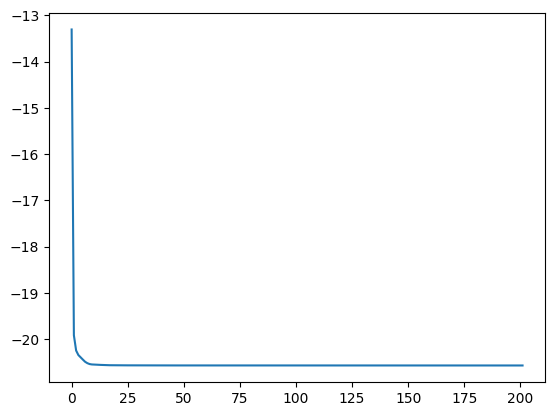

In [ ]:
import matplotlib.pyplot as plt

plt.plot(f_logs)

In [ ]:
exact_level = eval[0].real
D4_level = -20.529440911386118
exact_level

-20.568362531361974

In [ ]:
import pickle

with open('linear_rand_logs.pickle', 'rb') as f:
    rand_f_logs = pickle.load(f)['f_logs']
    
rand_f_logs[:5]

[array(-5.48974699),
 array(-8.16637053),
 array(-10.46691466),
 array(-12.67104459),
 array(-14.91373869)]

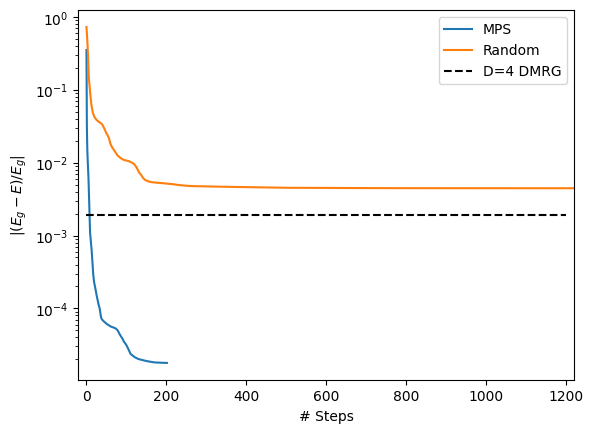

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(f_logs))+1, np.abs((exact_level-f_logs)/exact_level), label="MPS")
ax1.plot(np.arange(len(rand_f_logs))+1, np.abs((exact_level-rand_f_logs)/exact_level), label="Random")
ax1.hlines(np.abs((exact_level-D4_level)/exact_level), 0, 1200, colors='black', linestyles='--', label='D=4 DMRG')

ax1.set_yscale('log')
# ax1.set_ylim(0.1, 1.0)
ax1.set_xlim(-20, 1220)
ax1.set_xlabel('# Steps')
ax1.set_ylabel(r'$|(E_g-E)/E_g|$')
ax1.legend()
# ax1.set_xticks([20, 300, 500])
plt.show()

In [ ]:
data = {
    'f_logs': f_logs
}
with open('torch_kak_5linear_MPS_logs.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)